# はじめに
プライバシー保護を適用せずに、ニューラルネットワークの学習を行います。



## 概要
- CIAFR-10を用いてResNet18の学習を行う。
- 差分プライバシーを適用しないモデルのテスト精度を確認する。


## 参考資料
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html


# 実装

## 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

## 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [2]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
!nvidia-smi

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch: 1.13.1+cu116
Torchvision: 0.14.1+cu116
Sat Mar 11 00:36:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

## 3. データセットの用意  



### データセットの取得
カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を使用します。タスクは10クラス分類です。  
データセットのページからもダウンロードできますが、今回はtorchvisionを使用してデータセットを取得します。

torchvisionでは、データセットに適用する操作をtransformに指定できるので、ニューラルネットワークの学習用の操作を指定しておきます。


教師データとテストデータの両方に下記を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化


さらに、教師データには過学習を防止するために、ここでは2種類のdata augmentationを適用します。
- RandomCrop：ランダムに画像を切り抜く
- RandomHorizontalFlip：ランダムに左右反転

In [3]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip()])
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### ダウンロードされたデータの確認
0番目の教師データを表示します。  
data augmentationを適用しているので、表示するごとに異なる切り抜きと反転の操作が適用されていることが確認できます。  
また、画像はTensor型への変換と標準化が適用されているので、表示する前に逆変換が必要です。  

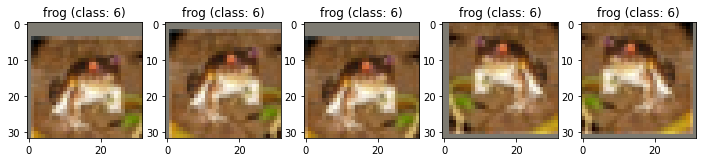

In [4]:
label_names = np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

plt.figure(figsize=(12.0, 4.0))
for i in range(1,6):
    x = training_data[0][0]
    x = x.mul(torch.FloatTensor(CIFAR10_STD).view(3, 1, 1))
    x = x.add(torch.FloatTensor(CIFAR10_MEAN).view(3, 1, 1)).detach().numpy()
    
    index = 150 + i
    plt.subplot(index)
    plt.imshow(np.transpose(x, (1, 2, 0)))
    plt.title(f'{label_names[training_data[0][1]]} (class: {training_data[0][1]})')

plt.show()


### DataLoaderの作成
バッチ学習で利用できるように、DataLoaderを作成します。  
教師データのバッチサイズは一般的な128に設定します。  
学習データでは、バッチ作成時にランダムなデータを選択するためにshuffleをTrueに指定します。


In [5]:
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

## 4. ニューラルネットワークの定義  
今回はtorchvisionのResNet18を使用します。  
詳細は下記論文を参照してください。  
[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)




In [6]:
model = torchvision.models.resnet18()

モデルは使用するデバイスを指定する必要があります。  
GPUを使用する場合は 'cuda' とします。


In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = model.to(device)

Using cuda device


## 5. 学習のための設定  
損失はクロスエントロピー、最適化方法は[Adam](https://arxiv.org/abs/1412.6980)を使用します。  
weight_decayは、過学習を防ぐためのパラメータの減衰率です。

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

## 6. 学習




### 学習ループ
学習を50エポック実施します。  
学習結果を確認するために、各エポック終了時にテストデータの損失と精度も計算します。

In [9]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []


for epoch in range(50):
    # training
    epoch_loss = []
    pred_list = []
    y_list = []
    model.train()
    for (X, y) in train_dataloader:
        X, y = X.to(device), y.to(device)

        # optimization step
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        y_list.extend(y.to('cpu').numpy().tolist())
        pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    train_loss.append(np.mean(epoch_loss))
    train_acc.append(metrics.accuracy_score(y_list, pred_list))

    # test
    model.eval()
    epoch_loss = []
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_loss.append(np.mean(epoch_loss))
    test_acc.append(metrics.accuracy_score(y_list, pred_list))
    print(f'[Epoch {epoch}] Train accuracy: {train_acc[-1]:0.2f}, Test accuracy: {test_acc[-1]:0.2f}, Train loss: {train_loss[-1]:0.3f}, Testloss: {test_loss[-1]:0.3f}')

  

[Epoch 0] Train accuracy: 0.45, Test accuracy: 0.46, Train loss: 1.561, Testloss: 1.559
[Epoch 1] Train accuracy: 0.59, Test accuracy: 0.61, Train loss: 1.154, Testloss: 1.109
[Epoch 2] Train accuracy: 0.64, Test accuracy: 0.69, Train loss: 1.004, Testloss: 0.886
[Epoch 3] Train accuracy: 0.68, Test accuracy: 0.67, Train loss: 0.908, Testloss: 0.977
[Epoch 4] Train accuracy: 0.71, Test accuracy: 0.73, Train loss: 0.836, Testloss: 0.777
[Epoch 5] Train accuracy: 0.73, Test accuracy: 0.73, Train loss: 0.782, Testloss: 0.794
[Epoch 6] Train accuracy: 0.75, Test accuracy: 0.74, Train loss: 0.733, Testloss: 0.761
[Epoch 7] Train accuracy: 0.76, Test accuracy: 0.76, Train loss: 0.700, Testloss: 0.706
[Epoch 8] Train accuracy: 0.77, Test accuracy: 0.75, Train loss: 0.666, Testloss: 0.729
[Epoch 9] Train accuracy: 0.78, Test accuracy: 0.78, Train loss: 0.644, Testloss: 0.655
[Epoch 10] Train accuracy: 0.79, Test accuracy: 0.78, Train loss: 0.617, Testloss: 0.643
[Epoch 11] Train accuracy: 0.80

### 学習結果の表示
学習結果として、教師データとテストデータの損失と精度を描画します。

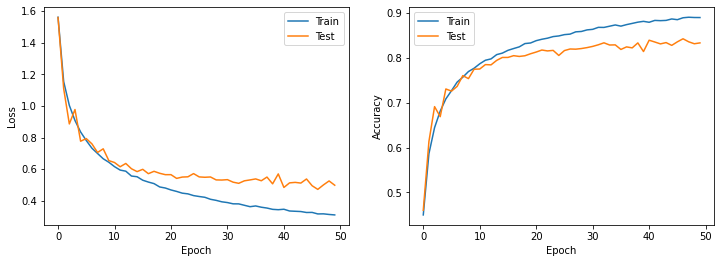

In [10]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# おわりに


## 今回の結果
今回の設定では、テスト精度は85%程度となりました。エポック数を増やせばもう少し精度は上がりそうです。  
他にテスト精度を上げるための方法としては、下記などがあると思います。
- data augmentation方法の改善
- 学習率を段階的に下げる[scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR)の設定
- label smoothingの適用

## 次にやること
差分プライバシーを適用して教師データのプライバシーを保護した場合のテスト精度を確認しようと思います。